In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from lxml import etree # 解析我们的xml
import os
from matplotlib.patches import Rectangle #绘制矩形框

In [2]:
print('Tensorflow version: {}'.format(tf.__version__))

Tensorflow version: 2.2.0


In [3]:
os.listdir('datasets/annotations/trimaps')[-5:]

['yorkshire_terrier_95.png',
 'yorkshire_terrier_96.png',
 'yorkshire_terrier_97.png',
 'yorkshire_terrier_98.png',
 'yorkshire_terrier_99.png']

In [4]:
img = tf.io.read_file('datasets/annotations/trimaps/yorkshire_terrier_95.png')

In [5]:
img = tf.image.decode_png(img)

In [6]:
img.shape

TensorShape([332, 500, 1])

In [7]:
#array([[1,2,3]])

In [8]:
# 压缩维度
img = tf.squeeze(img)

In [9]:
img.shape

TensorShape([332, 500])

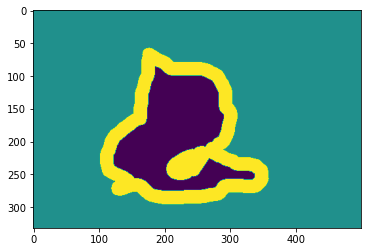

In [10]:
plt.imshow(img)

In [11]:
# 我们来查看如何进行标记
img.numpy()

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=uint8)

In [12]:
img.numpy().max()

3

In [13]:
# 分别代表三类像素，比如1背景2边缘3身体
np.unique(img.numpy())

array([1, 2, 3], dtype=uint8)

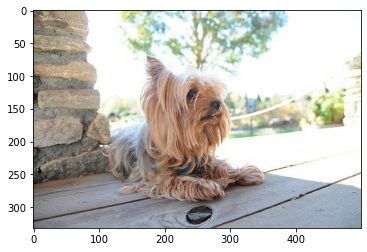

In [14]:
# 读取原有图片
img = tf.io.read_file('datasets/images/yorkshire_terrier_95.jpg')
img = tf.image.decode_jpeg(img)
plt.imshow(img)

In [15]:
import glob

In [16]:
images = glob.glob('datasets/images/*.jpg')

In [17]:
images[:3]

['datasets/images\\Abyssinian_1.jpg',
 'datasets/images\\Abyssinian_10.jpg',
 'datasets/images\\Abyssinian_100.jpg']

In [18]:
len(images)

7390

In [19]:
anno = glob.glob('datasets/annotations/trimaps/*.png')

In [20]:
anno[:3]

['datasets/annotations/trimaps\\Abyssinian_1.png',
 'datasets/annotations/trimaps\\Abyssinian_10.png',
 'datasets/annotations/trimaps\\Abyssinian_100.png']

In [21]:
# 因为是对应的 所以我们不进行排序
np.random.seed(2019)
index  =np.random.permutation(len(images))

In [22]:
# 做同样乱序，保证其实一样的
images =  np.array(images)[index]
anno = np.array(anno)[index]

In [23]:
dataset = tf.data.Dataset.from_tensor_slices((images,anno))

In [24]:
# 划分数据，分为测试数据和训练数据
test_count = int(len(images)*0.2)
train_count = len(images) - test_count

In [25]:
test_count,train_count

(1478, 5912)

In [26]:
# 我们对数据进行分割一下
data_train = dataset.skip(test_count)
data_test = dataset.take(test_count)

In [27]:
def read_jpg(path):
    img = tf.io.read_file(path)
    # 彩色图像 这里要显示 否则后面会出现none
    img = tf.image.decode_jpeg(img,channels=3)
    return img

In [28]:
def read_png(path):
    img = tf.io.read_file(path)
    # 通道数为1 
    img = tf.image.decode_png(img,channels=1)
    return img

In [29]:
# 编写归一化的函数 原图像0-255
def normal_img(input_images, input_anno):
    input_images = tf.cast(input_images,tf.float32)
    # 目标最好还是0开始
    input_images = input_images/127.5 - 1
    input_anno -= 1
    return input_images, input_anno

In [30]:
def load_images(input_images_path, input_anno_path):
    input_image = read_jpg(input_images_path)
    input_anno = read_png(input_anno_path)
    # 统一大小
    input_image = tf.image.resize(input_image,(224,224))
    input_anno = tf.image.resize(input_anno,(224,224))
    # 归一化
    return normal_img(input_image, input_anno)

In [31]:
data_train = data_train.map(load_images, 
                            num_parallel_calls = tf.data.experimental.AUTOTUNE) 

In [32]:
data_test = data_test.map(load_images, 
                            num_parallel_calls = tf.data.experimental.AUTOTUNE) 

In [33]:
BATCH_SIZE = 8

In [34]:
# 因为random已经随机了，所以shuffle() 100个是随机的
data_train =data_train.repeat().shuffle(100).batch(BATCH_SIZE)

In [35]:
# 不做repeat,shuffle
data_test =data_train.batch(BATCH_SIZE)

In [36]:
# 通道数是确定的，训练3，分割好的是1
data_train

<BatchDataset shapes: ((None, 224, 224, 3), (None, 224, 224, 1)), types: (tf.float32, tf.float32)>

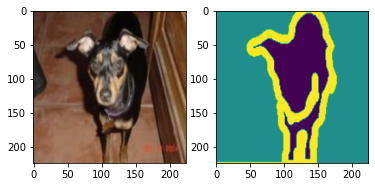

In [37]:
for img, anno in data_train.take(1):
    # 拿到一个batch图片，切0
    plt.subplot(1,2,1)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(img[0]))
    plt.subplot(1,2,2)
    plt.imshow(tf.keras.preprocessing.image.array_to_img(anno[0]))

# 使用训练网络

获取中间层的网络结果 比如使用VGG16

In [38]:
conv_base = tf.keras.applications.VGG16(weights='imagenet',
                                        input_shape=(224,224,3),
                                        include_top=False
                                       )

In [39]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [40]:
# 不断对MaxPooling层做上采用
conv_base.layers

In [41]:
conv_base.get_layer('block5_conv3').output

<tf.Tensor 'block5_conv3/Identity:0' shape=(None, 14, 14, 512) dtype=float32>

In [42]:
# 如何创建一个子model，输入是上一层，输出是这一层
sub_model = tf.keras.models.Model(inputs=conv_base.input,
                                  outputs=conv_base.get_layer('block5_conv3').output
                                 )

In [43]:
sub_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## 获取模型中间层输出 

In [44]:
# 通过前面的可以做到上采用，如何一次性获得多个输出
layer_names = [
    'block5_conv3',
    'block4_conv3',
    'block3_conv3',
    'block5_pool'
]

In [45]:
layers_output = [conv_base.get_layer(layer_name).output for layer_name in layer_names]

In [46]:
multi_out_model = tf.keras.models.Model(inputs=conv_base.input,
                                  outputs=layers_output
                                 )

In [47]:
multi_out_model.trainable = False

In [48]:
inputs = tf.keras.layers.Input(shape=(224,224,3))
out_block5_conv3, out_block4_conv3, out_block3_conv3, out = multi_out_model(inputs)

In [49]:
out.shape

TensorShape([None, 7, 7, 512])

In [50]:
out_block5_conv3.shape

TensorShape([None, 14, 14, 512])

In [51]:
out_block4_conv3.shape

TensorShape([None, 28, 28, 512])

In [52]:
out_block3_conv3.shape

TensorShape([None, 56, 56, 256])

In [53]:
# 我们对out层做上采用, 2倍
x1 = tf.keras.layers.Conv2DTranspose(512,
                                     3,
                                     strides=2,
                                     padding='same',
                                     activation='relu')(out)

In [54]:
x1.shape

TensorShape([None, 14, 14, 512])

In [55]:
# 默认strides 是1，1不改变大小
x1 = tf.keras.layers.Conv2D(512,3,padding='same',activation='relu')(x1)

In [56]:
x1.shape

TensorShape([None, 14, 14, 512])

In [57]:
x2 =tf.add(x1,out_block5_conv3)

In [58]:
x2.shape

TensorShape([None, 14, 14, 512])

In [59]:
# 对x2做上采样

In [60]:
x2 = tf.keras.layers.Conv2DTranspose(512,3,
                                     strides=2,
                                     padding='same',
                                     activation='relu')(x2)

In [61]:
x2.shape

TensorShape([None, 28, 28, 512])

In [62]:
x3 =tf.add(x2,out_block4_conv3)

In [63]:
x3.shape

TensorShape([None, 28, 28, 512])

In [64]:
# 对x3进行上采样
x3 = tf.keras.layers.Conv2DTranspose(256,3,
                                     strides=2,
                                     padding='same',
                                     activation='relu')(x3)

In [65]:
x3.shape

TensorShape([None, 56, 56, 256])

In [68]:
# 增加卷积提取特征
x3 = tf.keras.layers.Conv2D(256,3,padding='same',activation='relu')(x3)

In [69]:
x3.shape

TensorShape([None, 56, 56, 256])

In [70]:
x4 =tf.add(x3,out_block3_conv3)

In [71]:
# 这就是我们需要得到的结果，挑接结构就此完成
x4.shape

TensorShape([None, 56, 56, 256])

In [72]:
# 我们的目标输出是一个分类,输出与原有图像大小一样
# 对x4进行上采样
# 
x5 = tf.keras.layers.Conv2DTranspose(128,3,
                                     strides=2,
                                     padding='same',
                                     activation='relu')(x4)

In [73]:
x5.shape

TensorShape([None, 112, 112, 128])

In [74]:
x5 = tf.keras.layers.Conv2D(128,3,padding='same',activation='relu')(x5)

In [75]:
x5.shape

TensorShape([None, 112, 112, 128])

In [77]:
# 一步三采样，进行三分类
prediction = tf.keras.layers.Conv2DTranspose(3,3,
                                            strides=2,
                                            padding='same',
                                            activation='softmax')(x5)

In [78]:
prediction.shape

TensorShape([None, 224, 224, 3])

In [79]:
model = tf.keras.models.Model(
    inputs =inputs,
    outputs = prediction
)

In [80]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model_1 (Model)                 [(None, 14, 14, 512) 14714688    input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_transpose (Conv2DTranspo (None, 14, 14, 512)  2359808     model_1[1][3]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 14, 14, 512)  2359808     conv2d_transpose[0][0]           
____________________________________________________________________________________________

In [81]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['acc']
)

In [82]:
model.fit(data_train,
         epochs=5,
         steps_per_epoch=train_count//BATCH_SIZE,
         validation_data=data_test,
         validation_steps=test_count//BATCH_SIZE,)

Epoch 1/5
739/739 [==============================] - ETA: 0s - loss: 0.3506 - acc: 0.8614 WARNING:tensorflow:Model was constructed with shape (None, 224, 224, 3) for input Tensor("input_2:0", shape=(None, 224, 224, 3), dtype=float32), but it was called on an input with incompatible shape (None, None, 224, 224, 3).


ValueError: in user code:

    d:\webtool\lib\site-packages\tensorflow\python\keras\engine\training.py:941 test_function  *
        outputs = self.distribute_strategy.run(
    d:\webtool\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:951 run  **
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    d:\webtool\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2290 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    d:\webtool\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2649 _call_for_each_replica
        return fn(*args, **kwargs)
    d:\webtool\lib\site-packages\tensorflow\python\keras\engine\training.py:909 test_step  **
        y_pred = self(x, training=False)
    d:\webtool\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    d:\webtool\lib\site-packages\tensorflow\python\keras\engine\network.py:717 call
        return self._run_internal_graph(
    d:\webtool\lib\site-packages\tensorflow\python\keras\engine\network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    d:\webtool\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:927 __call__
        outputs = call_fn(cast_inputs, *args, **kwargs)
    d:\webtool\lib\site-packages\tensorflow\python\keras\engine\network.py:717 call
        return self._run_internal_graph(
    d:\webtool\lib\site-packages\tensorflow\python\keras\engine\network.py:888 _run_internal_graph
        output_tensors = layer(computed_tensors, **kwargs)
    d:\webtool\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:885 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs,
    d:\webtool\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:176 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer block1_conv1 is incompatible with the layer: expected ndim=4, found ndim=5. Full shape received: [None, None, 224, 224, 3]


In [ ]:
num = 3

In [ ]:
for image,mask in test_dataset.take(1):
    pred_mask = model.predict (image)
    # 取出预测的是哪一个类，像素点1，2，3 具体的分类
    pred_mask = tf.argmax (pred_mask, axis=-1)
    # 扩展维度，取前面所有的维度
    pred_mask = pred_mask[...， tf.newaxis]
    plt.figure (figsize=(10，10))
    for i in range (num):
        plt.subplot (num，3， i*num+1)
        # 原始图像
        plt.imshow (tf. keras. preprocessing. image. array_ to_ img (image[i]))
        # 真实分割图
        plt.subplot (num, 3，i*num+2)
        plt.imshow (tf. keras. preprocessing. image. array_ _to_ img (mask[i]))
        # 预测图
        plt.subplot (num, 3， i*num+3)
        plt.imshow (tf. keras. preprocessing. image. array_ to_ img(pred_ mask[i]))
